In [1]:
import fml_lib
import numpy as np
import pandas as pd
import scipy.stats as ss
import os.path
from math import sqrt, exp, log
import matplotlib.pyplot as plt
from mp_engine import mpPandasObj
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [2]:
dollar_bars = pd.read_csv("USA500IDXUSD_hourly_bars.csv", parse_dates=[['Date', 'Timestamp']])
dollar_bars = dollar_bars.set_index("Date_Timestamp")
dollar_bars = dollar_bars.dropna()
close = dollar_bars['Close']
ffd_close = np.log(dollar_bars[['Close']]).cumsum()
print(ffd_close)


                             Close
Date_Timestamp                    
2019-04-17 00:00:00       7.975176
2019-04-17 01:00:00      15.951658
2019-04-17 02:00:00      23.927521
2019-04-17 03:00:00      31.903144
2019-04-17 04:00:00      39.878664
...                            ...
2024-04-16 18:00:00  243348.708861
2024-04-16 19:00:00  243357.236147
2024-04-16 20:00:00  243365.763374
2024-04-16 22:00:00  243374.292003
2024-04-16 23:00:00  243382.822105

[29496 rows x 1 columns]


C:\Users\dstek\AppData\Local\Temp\ipykernel_30024\128212720.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  dollar_bars = pd.read_csv("USA500IDXUSD_hourly_bars.csv", parse_dates=[['Date', 'Timestamp']])


In [3]:
def plotMinFFD():
    from statsmodels.tsa.stattools import adfuller
    import matplotlib.pyplot as mpl
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    df0=dollar_bars
    for d in np.linspace(0.9,1,31):
        df1=np.cumsum(np.log(df0[['Close']])).resample('1D').last() # downcast to daily obs
        df2=fml_lib.fracDiff_FFD(df1,d,thres=1E-3)
        corr=np.corrcoef(df1.loc[df2.index,'Close'],df2['Close'])[0,1]
        df2=adfuller(df2['Close'],maxlag=1,regression='c',autolag=None)
       
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
    out.to_csv('./_testMinFFD.csv')
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    mpl.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
    mpl.savefig('./_testMinFFD.png')
    return

In [4]:
test_ffd = fml_lib.fracDiff_FFD(ffd_close,0.97)
ffd_std = test_ffd.std()[0]
#print(ffd_std)
daily_volatility = fml_lib.getDailyVol(test_ffd.Close,span0=100)

c:\Users\dstek\Documents\ECE479\fml_lib.py:285: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()


58


C:\Users\dstek\AppData\Local\Temp\ipykernel_30024\3059649216.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ffd_std = test_ffd.std()[0]


In [5]:
print(test_ffd)
print(daily_volatility)

                          Close
2019-04-22 12:00:00    9.156934
2019-04-22 13:00:00    9.164251
2019-04-22 14:00:00    9.169456
2019-04-22 15:00:00    9.174572
2019-04-22 16:00:00    9.179339
...                         ...
2024-04-16 18:00:00  154.018949
2024-04-16 19:00:00  154.019507
2024-04-16 20:00:00  154.024411
2024-04-16 22:00:00  154.030827
2024-04-16 23:00:00  154.037373

[29438 rows x 1 columns]
2019-04-23 13:00:00         NaN
2019-04-23 14:00:00    0.000056
2019-04-23 15:00:00    0.000185
2019-04-23 16:00:00    0.000196
2019-04-23 17:00:00    0.000185
                         ...   
2024-04-16 18:00:00    0.000181
2024-04-16 19:00:00    0.000180
2024-04-16 20:00:00    0.000179
2024-04-16 22:00:00    0.000178
2024-04-16 23:00:00    0.000177
Name: Close, Length: 29414, dtype: float64


In [6]:

if os.path.exists("./t_events.csv"):
    t_events = pd.read_csv("t_events.csv", index_col=[0])
    t_events = t_events.index
else:
    t_events = fml_lib.getTEvents(test_ffd.Close, 2*daily_volatility)
    t_events_df = pd.DataFrame(index= t_events)
    t_events_df.to_csv("./t_events_csv", index=True)

c:\Users\dstek\Documents\ECE479\fml_lib.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sNeg<-h.iloc[h.index.get_indexer([i], method='nearest')][0]:
c:\Users\dstek\Documents\ECE479\fml_lib.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif sPos>h.iloc[h.index.get_indexer([i], method='nearest')][0]:


In [7]:
print(t_events)

DatetimeIndex(['2019-04-23 14:00:00', '2019-04-23 15:00:00',
               '2019-04-23 16:00:00', '2019-04-23 17:00:00',
               '2019-04-23 18:00:00', '2019-04-23 19:00:00',
               '2019-04-23 20:00:00', '2019-04-23 22:00:00',
               '2019-04-23 23:00:00', '2019-04-24 00:00:00',
               ...
               '2024-04-16 13:00:00', '2024-04-16 14:00:00',
               '2024-04-16 15:00:00', '2024-04-16 16:00:00',
               '2024-04-16 17:00:00', '2024-04-16 18:00:00',
               '2024-04-16 19:00:00', '2024-04-16 20:00:00',
               '2024-04-16 22:00:00', '2024-04-16 23:00:00'],
              dtype='datetime64[ns]', length=28277, freq=None)


In [8]:
test_ffd['original_close'] = close.loc[t_events]
test_ffd['Close'] = test_ffd['Close'].loc[t_events]
test_ffd = test_ffd.dropna()
print(test_ffd)
#adds the vertical barrier num_days out from the time of the event
numDays = 5
t1=test_ffd.index.searchsorted(t_events+pd.Timedelta(days=numDays))
t1=t1[t1<test_ffd.shape[0]]
t1=pd.Series(test_ffd.index[t1],index=t_events[:t1.shape[0]]) # NaNs at end

                          Close  original_close
2019-04-23 14:00:00    9.284123        2920.470
2019-04-23 15:00:00    9.292608        2931.169
2019-04-23 16:00:00    9.298190        2933.170
2019-04-23 17:00:00    9.302872        2932.669
2019-04-23 18:00:00    9.308194        2934.170
...                         ...             ...
2024-04-16 18:00:00  154.018949        5073.976
2024-04-16 19:00:00  154.019507        5050.723
2024-04-16 20:00:00  154.024411        5050.421
2024-04-16 22:00:00  154.030827        5057.506
2024-04-16 23:00:00  154.037373        5064.960

[28277 rows x 2 columns]


In [9]:
min_ret= 0.005
#trgt = pd.Series(0.01, index=t_events)
trgt = 2*daily_volatility
'''
if os.path.exists("./events.csv"):
    events = pd.read_csv("events.csv", index_col=[0])
    events = events.dropna()
else:
    events = fml_lib.getEvents(close, t_events, 0.02,np.log(trgt) , np.log(min_ret),t1)
    events.to_csv("events.csv")
'''
events = fml_lib.getEvents(test_ffd['original_close'], t_events, 0.02,trgt , min_ret,t1)
events.to_csv("events.csv")

datetime64[ns]


In [10]:
print(events)

                                     t1      trgt  side
2019-04-29 00:00:00 2019-04-29 02:00:00  0.005987   1.0
2019-04-29 02:00:00 2019-04-29 06:00:00  0.007055   1.0
2019-04-29 04:00:00 2019-04-29 06:00:00  0.007639   1.0
2019-04-29 06:00:00 2019-04-29 08:00:00  0.007932   1.0
2019-04-29 08:00:00 2019-04-29 11:00:00  0.008030   1.0
...                                 ...       ...   ...
2019-06-24 13:00:00 2019-06-24 14:00:00  0.005399   1.0
2019-06-24 14:00:00 2019-06-24 16:00:00  0.005354   1.0
2019-06-24 16:00:00 2019-06-24 18:00:00  0.005253   1.0
2019-06-24 18:00:00 2019-06-24 20:00:00  0.005150   1.0
2019-06-24 20:00:00 2019-06-24 23:00:00  0.005056   1.0

[237 rows x 3 columns]


In [11]:
print(close)

Date_Timestamp
2019-04-17 00:00:00    2907.870
2019-04-17 01:00:00    2911.669
2019-04-17 02:00:00    2909.869
2019-04-17 03:00:00    2909.169
2019-04-17 04:00:00    2908.869
                         ...   
2024-04-16 18:00:00    5073.976
2024-04-16 19:00:00    5050.723
2024-04-16 20:00:00    5050.421
2024-04-16 22:00:00    5057.506
2024-04-16 23:00:00    5064.960
Name: Close, Length: 29496, dtype: float64


In [12]:
close = test_ffd['original_close']
out = fml_lib.getBins(events, close, numDays)
out['close'] = close.loc[out.index]
out = out.drop(columns=['ret'])
print(out)


                     bin     close
2019-04-29 00:00:00  1.0  2938.670
2019-04-29 02:00:00 -1.0  2939.969
2019-04-29 04:00:00 -1.0  2939.970
2019-04-29 06:00:00  1.0  2939.470
2019-04-29 08:00:00 -1.0  2941.370
...                  ...       ...
2019-06-24 13:00:00  1.0  2948.370
2019-06-24 14:00:00 -1.0  2951.069
2019-06-24 16:00:00 -1.0  2950.569
2019-06-24 18:00:00 -1.0  2948.070
2019-06-24 20:00:00  1.0  2946.970

[237 rows x 2 columns]


In [13]:
print(events)

                                     t1      trgt  side
2019-04-29 00:00:00 2019-04-29 02:00:00  0.005987   1.0
2019-04-29 02:00:00 2019-04-29 06:00:00  0.007055   1.0
2019-04-29 04:00:00 2019-04-29 06:00:00  0.007639   1.0
2019-04-29 06:00:00 2019-04-29 08:00:00  0.007932   1.0
2019-04-29 08:00:00 2019-04-29 11:00:00  0.008030   1.0
...                                 ...       ...   ...
2019-06-24 13:00:00 2019-06-24 14:00:00  0.005399   1.0
2019-06-24 14:00:00 2019-06-24 16:00:00  0.005354   1.0
2019-06-24 16:00:00 2019-06-24 18:00:00  0.005253   1.0
2019-06-24 18:00:00 2019-06-24 20:00:00  0.005150   1.0
2019-06-24 20:00:00 2019-06-24 23:00:00  0.005056   1.0

[237 rows x 3 columns]


Want to find sample weights for use in the boosting fit

In [14]:
temp = list(set(pd.to_datetime(events.t1.index)) & set(pd.to_datetime(events.index)) )

In [15]:
#test_co_events = mpPandasObj(fml_lib.mpNumCoEvents,('molecule',events.index),24, closeIdx=close.index,t1=events['t1'])

if os.path.exists("./t_events.csv"):  
    numCoEvents = pd.read_csv("./co_events.csv", index_col=[0])
else:
    numCoEvents = fml_lib.get_co_events(close,events)
    numCoEvents.to_csv("./co_events.csv", index=True)

2019-04-29 00:00:00    1
2019-04-29 02:00:00    2
2019-04-29 04:00:00    2
2019-04-29 06:00:00    3
2019-04-29 08:00:00    2
                      ..
2019-06-24 14:00:00    2
2019-06-24 16:00:00    2
2019-06-24 18:00:00    2
2019-06-24 20:00:00    2
2019-06-24 23:00:00    1
Length: 627, dtype: int64


In [16]:

old_index = numCoEvents.index
old_co = numCoEvents.values

In [17]:
numCoEvents=numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents=numCoEvents.reindex(close.index,fill_value=0)
numCoEvents.loc[old_index] = old_co
print(numCoEvents.loc[old_index])
print(numCoEvents)

2019-04-29 00:00:00    1
2019-04-29 02:00:00    2
2019-04-29 04:00:00    2
2019-04-29 06:00:00    3
2019-04-29 08:00:00    2
                      ..
2019-06-24 14:00:00    2
2019-06-24 16:00:00    2
2019-06-24 18:00:00    2
2019-06-24 20:00:00    2
2019-06-24 23:00:00    1
Length: 627, dtype: int64
2019-04-23 14:00:00    0
2019-04-23 15:00:00    0
2019-04-23 16:00:00    0
2019-04-23 17:00:00    0
2019-04-23 18:00:00    0
                      ..
2024-04-16 18:00:00    0
2024-04-16 19:00:00    0
2024-04-16 20:00:00    0
2024-04-16 22:00:00    0
2024-04-16 23:00:00    0
Length: 28277, dtype: int64


In [18]:
numThreads = 12

out['tW']=mpPandasObj(fml_lib.mpSampleTW,('molecule',events.index),numThreads, t1=events['t1'],numCoEvents=numCoEvents)

2024-04-24 18:51:36.207816 100.0% mpSampleTW done after 0.05 minutes. Remaining 0.0 minutes..
c:\Users\dstek\Documents\ECE479\mp_engine.py:123: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df0=df0._append(i)


In [19]:

out['w'] = mpPandasObj(fml_lib.mpSampleW,('molecule',events.index),numThreads, t1=events['t1'],numCoEvents=numCoEvents,close=close)
print(out['w'])

2024-04-24 18:51:39.851380 100.0% mpSampleW done after 0.05 minutes. Remaining 0.0 minutes..


2019-04-29 00:00:00    0.000221
2019-04-29 02:00:00    0.000164
2019-04-29 04:00:00   -0.000057
2019-04-29 06:00:00    0.000266
2019-04-29 08:00:00   -0.000392
                         ...   
2019-06-24 13:00:00   -0.000034
2019-06-24 14:00:00    0.000373
2019-06-24 16:00:00   -0.000508
2019-06-24 18:00:00   -0.000610
2019-06-24 20:00:00   -0.000085
Name: w, Length: 237, dtype: float64


c:\Users\dstek\Documents\ECE479\mp_engine.py:123: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df0=df0._append(i)


In [20]:
out['ffd_value'] = test_ffd.loc[out.index]['Close']

In [21]:
print(out)

                     bin     close        tW         w  ffd_value
2019-04-29 00:00:00  1.0  2938.670  0.750000  0.000221   9.660999
2019-04-29 02:00:00 -1.0  2939.969  0.444444  0.000164   9.670972
2019-04-29 04:00:00 -1.0  2939.970  0.416667 -0.000057   9.680507
2019-04-29 06:00:00  1.0  2939.470  0.416667  0.000266   9.689869
2019-04-29 08:00:00 -1.0  2941.370  0.500000 -0.000392   9.700027
...                  ...       ...       ...       ...        ...
2019-06-24 13:00:00  1.0  2948.370  0.500000 -0.000034  14.047657
2019-06-24 14:00:00 -1.0  2951.069  0.500000  0.000373  14.053285
2019-06-24 16:00:00 -1.0  2950.569  0.500000 -0.000508  14.062623
2019-06-24 18:00:00 -1.0  2948.070  0.500000 -0.000610  14.071227
2019-06-24 20:00:00  1.0  2946.970  0.750000 -0.000085  14.080293

[237 rows x 5 columns]


In [22]:
ind_matrix = fml_lib.getIndMatrix(dollar_bars.index,events['t1'])
#bootstrap_indices = fml_lib.seqBootstrap(ind_matrix)
#bootstrap_indices = fml_lib.main_mp(events['t1'], 100, 4)
bootstrap_indices = pd.read_csv("./bootstrap.csv", index_col=[0]).values
actual_bootstrap = []
for index in bootstrap_indices:
    actual_bootstrap.append(index[0])
print(actual_bootstrap)

[190, 109, 74, 216, 163, 236, 154, 100, 4, 206, 65, 66, 211, 176, 167, 56, 116, 209, 26, 104, 87, 204, 1, 112, 68, 86, 138, 42, 229, 165, 153, 82, 180, 63, 68, 64, 126, 96, 219, 133, 85, 74, 171, 157, 182, 215, 98, 80, 218, 43, 217, 156, 19, 44, 106, 72, 36, 126, 31, 120, 224, 160, 33, 164, 83, 120, 220, 89, 105, 204, 199, 131, 183, 148, 187, 53, 176, 12, 112, 228, 64, 102, 213, 26, 116, 208, 123, 179, 18, 162, 167, 78, 25, 173, 180, 20, 143, 186, 149, 182, 59, 62, 206, 193, 131, 155, 67, 4, 78, 147, 102, 199, 83, 166, 53, 23, 8, 57, 186, 129, 40, 227, 224, 70, 81, 149, 35, 122, 7, 72, 215, 202, 133, 108, 135, 196, 24, 19, 159, 73, 122, 50, 145, 166, 195, 26, 214, 15, 3, 105, 26, 233, 154, 214, 106, 99, 222, 226, 25, 211, 211, 42, 51, 37, 103, 117, 24, 35, 59, 57, 198, 118, 177, 234, 96, 6, 127, 45, 98, 199, 228, 147, 34, 17, 139, 75, 134, 73, 60, 30, 192, 152, 141, 72, 68, 76, 221, 174, 130, 187, 63, 12, 190, 92, 158, 46, 179, 20, 32, 170, 47, 79, 11, 229, 0, 84, 34, 35, 71, 197, 44, 

In [23]:
seqU = fml_lib.getAvgUniqueness(ind_matrix[actual_bootstrap]).mean()
print(seqU)

0.5217804121179647


In [24]:
y = out['bin'].values.reshape(-1,1)
print(y)

[[ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]

In [25]:
print(out)

                     bin     close        tW         w  ffd_value
2019-04-29 00:00:00  1.0  2938.670  0.750000  0.000221   9.660999
2019-04-29 02:00:00 -1.0  2939.969  0.444444  0.000164   9.670972
2019-04-29 04:00:00 -1.0  2939.970  0.416667 -0.000057   9.680507
2019-04-29 06:00:00  1.0  2939.470  0.416667  0.000266   9.689869
2019-04-29 08:00:00 -1.0  2941.370  0.500000 -0.000392   9.700027
...                  ...       ...       ...       ...        ...
2019-06-24 13:00:00  1.0  2948.370  0.500000 -0.000034  14.047657
2019-06-24 14:00:00 -1.0  2951.069  0.500000  0.000373  14.053285
2019-06-24 16:00:00 -1.0  2950.569  0.500000 -0.000508  14.062623
2019-06-24 18:00:00 -1.0  2948.070  0.500000 -0.000610  14.071227
2019-06-24 20:00:00  1.0  2946.970  0.750000 -0.000085  14.080293

[237 rows x 5 columns]


In [26]:
out = out.drop(columns=['bin'], axis = 1)

x = out.values
print(x)

[[ 2.93867000e+03  7.50000000e-01  2.20969517e-04  9.66099897e+00]
 [ 2.93996900e+03  4.44444444e-01  1.64444845e-04  9.67097221e+00]
 [ 2.93997000e+03  4.16666667e-01 -5.65246722e-05  9.68050655e+00]
 [ 2.93947000e+03  4.16666667e-01  2.66388366e-04  9.68986855e+00]
 [ 2.94137000e+03  5.00000000e-01 -3.91550360e-04  9.70002686e+00]
 [ 2.93716900e+03  5.00000000e-01  1.52796595e-04  9.71280618e+00]
 [ 2.94226900e+03  5.00000000e-01  9.69381794e-04  9.72404265e+00]
 [ 2.94286900e+03  5.00000000e-01  7.81099192e-04  9.73381384e+00]
 [ 2.94686900e+03  5.00000000e-01 -5.08033471e-05  9.74473091e+00]
 [ 2.94257000e+03  5.00000000e-01 -1.17193678e-03  9.75281068e+00]
 [ 2.93997000e+03  5.00000000e-01 -6.63125561e-04  9.76136091e+00]
 [ 2.93867000e+03  5.00000000e-01 -3.40255273e-04  9.77036775e+00]
 [ 2.93797000e+03  5.00000000e-01 -2.89330192e-04  9.77956385e+00]
 [ 2.93697000e+03  5.00000000e-01  8.50855282e-05  9.78870572e+00]
 [ 2.93847000e+03  5.00000000e-01  3.40371086e-04  9.79869225e

In [27]:
def evaluate(X,y,clf):
    from sklearn import metrics
    # The random forest model by itself
    y_pred_rf = clf.predict_proba(X)[:, 1]
    y_pred = clf.predict(X)
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y, y_pred_rf)
    print(metrics.classification_report(y, y_pred))

    plt.figure(figsize=(9,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='clf')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=777)

In [29]:
base_clf = DecisionTreeClassifier(criterion='entropy',
                                  class_weight='balanced')
bc = BaggingClassifier(estimator=base_clf,n_estimators=1000,
                       max_samples=seqU,max_features=1.,random_state=777)

In [30]:
fit  =  bc.fit(X_train, y_train)

C:\Users\dstek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

        -1.0       0.74      0.70      0.72        33
         1.0       0.76      0.79      0.78        39

    accuracy                           0.75        72
   macro avg       0.75      0.75      0.75        72
weighted avg       0.75      0.75      0.75        72



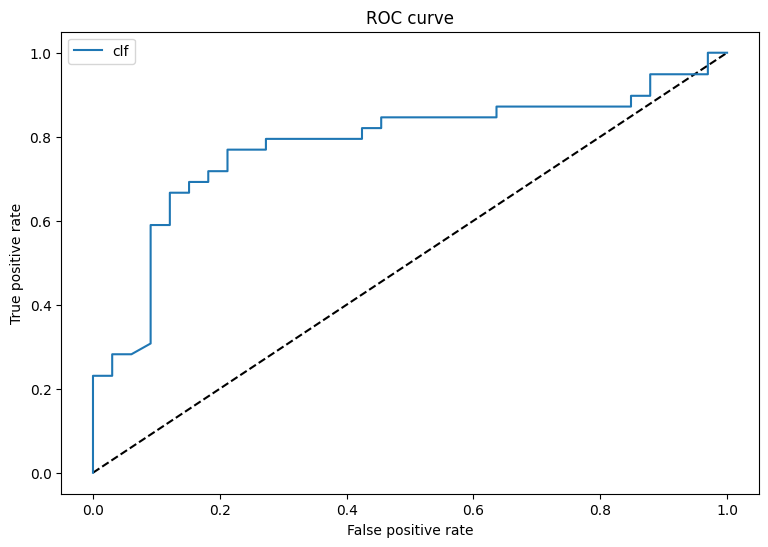

In [31]:
evaluate(X_test,y_test,fit)

C:\Users\dstek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_bagging.py:782: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

        -1.0       0.74      0.70      0.72        33
         1.0       0.76      0.79      0.78        39

    accuracy                           0.75        72
   macro avg       0.75      0.75      0.75        72
weighted avg       0.75      0.75      0.75        72



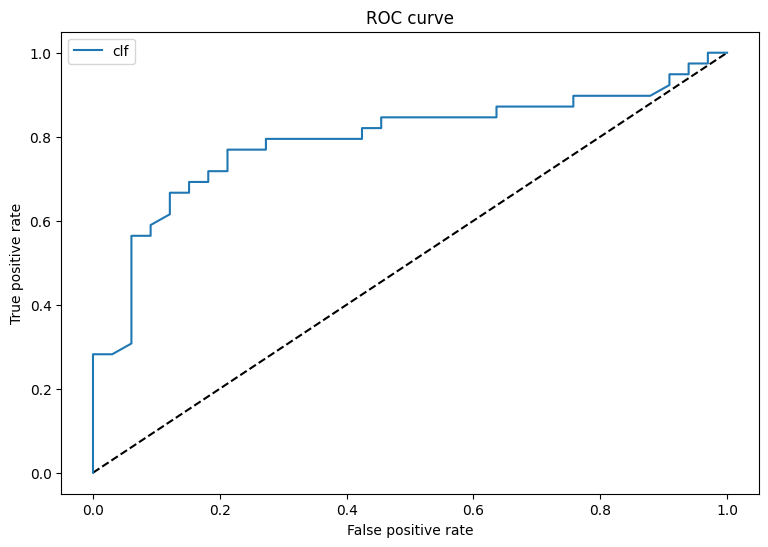

In [32]:
rf_clf  =  RandomForestClassifier(n_estimators=1,
                                class_weight='balanced_subsample',
                                criterion='entropy', 
                                bootstrap=False)
bc_rf = BaggingClassifier(estimator=rf_clf, n_estimators=1000,
                          max_samples=seqU, max_features=1., 
                          random_state=777)

fit = bc_rf.fit(X_train,y_train)
evaluate(X_test,y_test,fit)

In [33]:
print(out)

                        close        tW         w  ffd_value
2019-04-29 00:00:00  2938.670  0.750000  0.000221   9.660999
2019-04-29 02:00:00  2939.969  0.444444  0.000164   9.670972
2019-04-29 04:00:00  2939.970  0.416667 -0.000057   9.680507
2019-04-29 06:00:00  2939.470  0.416667  0.000266   9.689869
2019-04-29 08:00:00  2941.370  0.500000 -0.000392   9.700027
...                       ...       ...       ...        ...
2019-06-24 13:00:00  2948.370  0.500000 -0.000034  14.047657
2019-06-24 14:00:00  2951.069  0.500000  0.000373  14.053285
2019-06-24 16:00:00  2950.569  0.500000 -0.000508  14.062623
2019-06-24 18:00:00  2948.070  0.500000 -0.000610  14.071227
2019-06-24 20:00:00  2946.970  0.750000 -0.000085  14.080293

[237 rows x 4 columns]


In [34]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bc_rf.estimators_
], axis=0)
print(feature_importances)

[0.22889754 0.04749139 0.50662021 0.21699085]
